# Monitor Data Drift over years
<b>With this tutorial you:</b><br />
Understand how to use Eurybia to detect datadrift

Contents:
- Detect data drift  
- Compile Drift over years



**Requirements notice** : the following tutorial may use third party modules not included in Eurybia.  
You can find them all in one file [on our Github repository](https://github.com/MAIF/eurybia/blob/master/requirements.dev.txt) or you can manually install those you are missing, if any.

In [2]:
import pandas as pd
import numpy as np
from category_encoders import OrdinalEncoder
from lightgbm import LGBMRegressor
from eurybia import SmartDrift
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

/Users/78176D/workspace/eurybia/eurybia/report/generation.py:18: UserWarning:

Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.



## Import Dataset and split in training and production dataset

In [3]:
from eurybia.data.data_loader import data_loading

In [4]:
house_df, house_dict = data_loading('house_prices')

In [5]:
# Let us consider that the column "YrSold" corresponds to the reference date. 
#In 2006, a model was trained using data. And in 2007, we want to detect data drift on new data in production to predict
#house price
house_df_learning = house_df.loc[house_df['YrSold'] == 2006]
house_df_2007 = house_df.loc[house_df['YrSold'] == 2007]

In [6]:
y_df_learning=house_df_learning['SalePrice'].to_frame()
X_df_learning=house_df_learning[house_df_learning.columns.difference(['SalePrice','YrSold'])]

y_df_2007=house_df_2007['SalePrice'].to_frame()
X_df_2007=house_df_2007[house_df_2007.columns.difference(['SalePrice','YrSold'])]

## Building Supervized Model

In [7]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df_learning.columns if X_df_learning[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df_learning)

X_df_learning_encoded=encoder.transform(X_df_learning)

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df_learning_encoded, y_df_learning, train_size=0.75, random_state=1)

In [9]:
regressor = LGBMRegressor(n_estimators=200).fit(Xtrain,ytrain)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 235, number of used features: 53
[LightGBM] [Info] Start training from score 181743.472340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

## Use Eurybia for data drift

In [10]:
from eurybia import SmartDrift

In [11]:
X_df_2007["MasVnrType"] = X_df_2007["MasVnrType"].fillna("NR")
X_df_learning["MasVnrType"]=X_df_learning["MasVnrType"].fillna("NR")

In [12]:
SD = SmartDrift(df_current=X_df_2007,
                df_baseline=X_df_learning,
                deployed_model=regressor, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
                )

In [13]:
%time 
from datetime import date
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = date(2007,1,1), # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "house_price_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
            )
                 

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 6.2 μs
The variable BsmtCond has mismatching unique values:
['Poor -Severe cracking, settling, or wetness'] | []

The variable Condition2 has mismatching unique values:
['Near positive off-site feature--park, greenbelt, etc.', 'Adjacent to North-South Railroad', 'Adjacent to East-West Railroad'] | ['Adjacent to feeder street']

The variable Electrical has mismatching unique values:
['Mixed'] | ['60 AMP Fuse Box and mostly knob & tube wiring (poor)']

The variable ExterQual has mismatching unique values:
['Fair'] | []

The variable Exterior1st has mismatching unique values:
[] | ['Stone', 'Imitation Stucco']

The variable Exterior2nd has mismatching unique values:
['Asphalt Shingles', 'Brick Common'] | ['Other']

The variable Foundation has mismatching unique values:
[] | ['Stone', 'Wood']

The variable Functional has mismatching unique values:
['Major Deductions 2', 'Severely Damaged'] | ['Moderate Deductions']

The variable G

As soon as compile() method, Eurybia displays default consistency checks as warnings.<br />
If some modalities are not present during training and are in production dataset, the deployed model will consider them wrongly.<br />
Inversely, if some modalities are present during training and are not in production dataset, it means that some profiles are missing.

In [14]:
SD.generate_report(    
    output_file='report_house_price_datadrift_2007.html',    
    title_story="Data drift",
    title_description="""House price Data drift 2007""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_house_price.yml" # Optional: add information on report
    )

Eurybia is designed to generate an HTML report for analysis, and less for use in notebook mode. 
However, to illustrate functionalities, we will detail results with notebook mode analysis.

## First Analysis of results of the data drift

Data driftn methodology is based on the ability of a model to discriminate whether an individual belongs to one of the two datasets.
For this purpose a target 0 is assigned to the baseline dataset and a target 1 to the current dataset.
Then a classification model (catboost) is learned to predict this target.
The level of capacity of the data drift classifier to detect if an individual belongs to one of the 2 datasets represents the level of difference between the 2 datasets

### Detection data drift performance

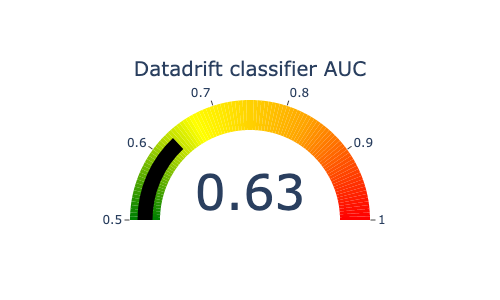

In [ ]:
#Performance of datadrift classifier
SD.plot.generate_indicator(fig_value=SD.auc, height=300, width=500, title="Datadrift classifier AUC")

An Auc close to 0.5 means that there is little drift

### Importance of features in data drift

This graph represents the variables in the data drift classification model that are most important to differentiate between the two datasets.

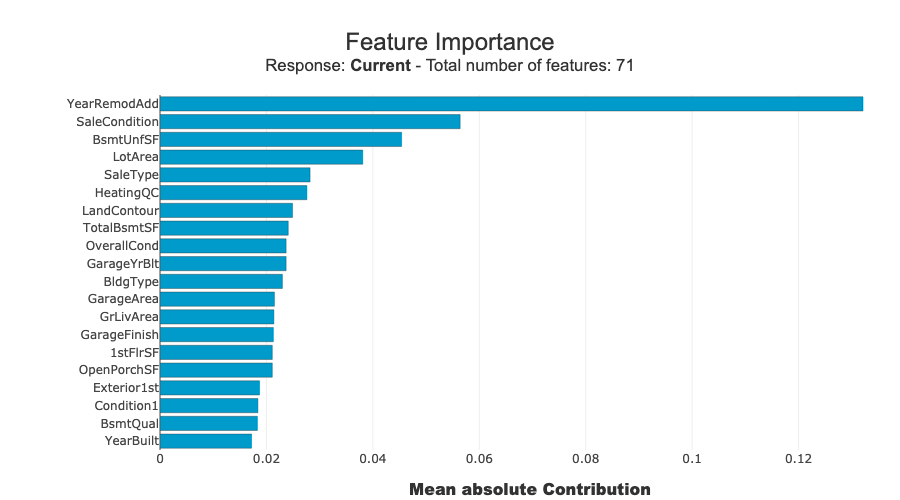

In [ ]:
SD.xpl.plot.features_importance()

We get the features with most gaps, those that are most important to analyse.
With date bias introduced, it is normal that date features are the most impacted. We will then decide to remove them.
Let's analyse other important variables

### Feature importance overview

This graph compares the importance of variables between the data drift classifier model and the deployed model. This allows us to put into perspective the importance of data drift in relation to the impacts to be expected on the deployed model. If the variable is at the top left, it means that the variable is very important for data drift classification, but that the variable has little influence on the deployed model. If the variable is at the bottom right, it means that the variable has little importance for data drift classification, and that the variable has a lot of influence on the deployed model.

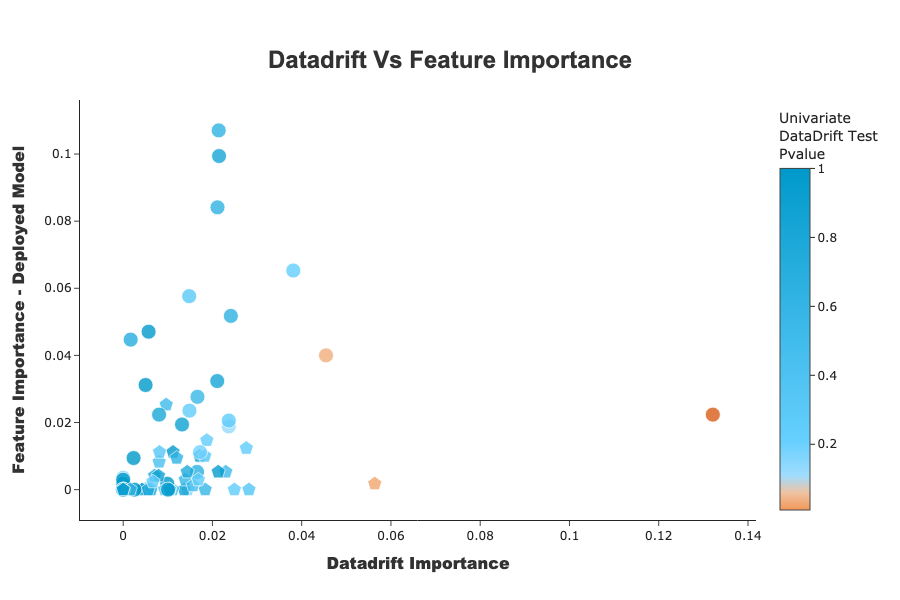

In [ ]:
SD.plot.scatter_feature_importance() # works if deployed_model is filled

Putting importance of the drift into perspective according to the importance of the model to be deployed, can help the data scientist to validate that his model can be deployed. <br />


### Univariate analysis

This graphs shows a particular feature's distribution over its possible values. In the drop-down menu, the variables are sorted by importance of the variables in the data drift classification. For categorical features, the possible values are sorted by descending difference between the two datasets.

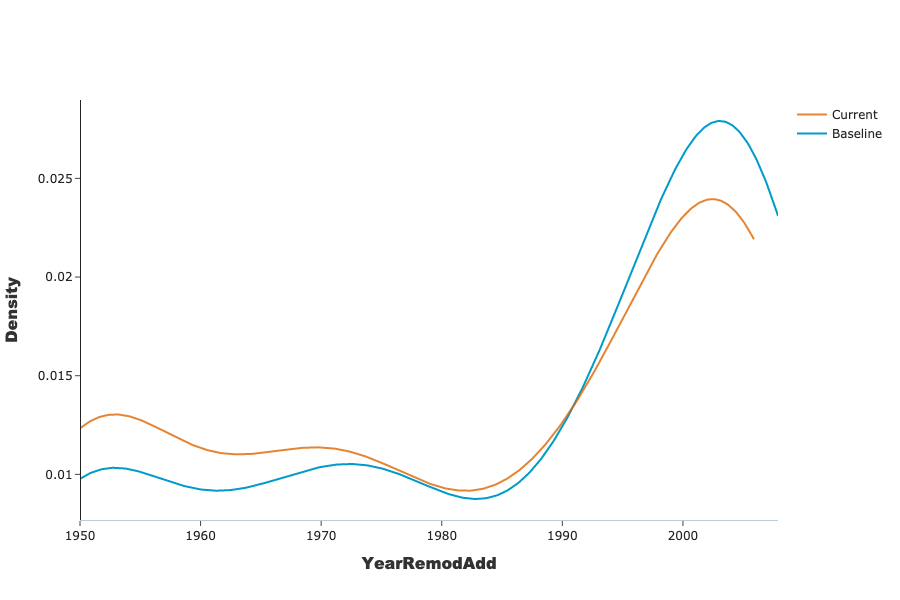

In [ ]:
SD.plot.generate_fig_univariate('YearRemodAdd')

### Distribution of predicted values

This graph shows distributions of the production model outputs on both baseline and current datasets.

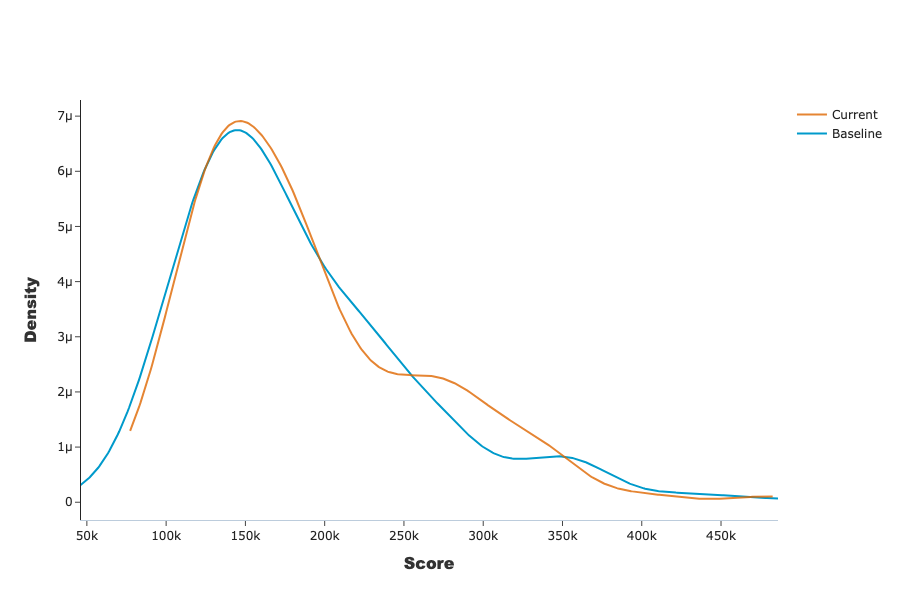

In [ ]:
SD.plot.generate_fig_univariate(df_all=SD.df_predict,col='Score',hue="dataset") # works if deployed_model is filled

Jensen Shannon Divergence (JSD). The JSD measures the effect of a data drift on the deployed model performance. A value close to 0 indicates similar data distributions, while a value close to 1 tend to indicate distinct data distributions with a negative effect on the deployed model performance.

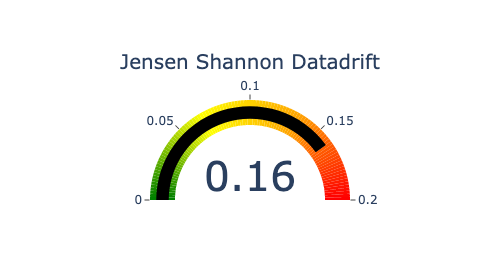

In [ ]:
SD.plot.generate_indicator(
                fig_value=SD.js_divergence,
                height=280,
                width=500,
                title="Jensen Shannon Datadrift",
                min_gauge=0,
                max_gauge=0.2,
            ) #works if deployed_model is filled

## Compile Drift over years

### Compile Drift et generate report for Year 2008

In [21]:
house_df_2008 = house_df.loc[house_df['YrSold'] == 2008]

y_df_2008=house_df_2008['SalePrice'].to_frame()
X_df_2008=house_df_2008[house_df_2008.columns.difference(['SalePrice','YrSold'])]
X_df_2008["MasVnrType"] = X_df_2008["MasVnrType"].fillna("NR")

In [22]:
SD = SmartDrift(df_current=X_df_2008,
                df_baseline=X_df_learning,
                deployed_model=regressor, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [23]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = date(2008,1,1),#'01/01/2008', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "house_price_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The variable Condition1 has mismatching unique values:
["Within 200' of East-West Railroad"] | []

The variable Condition2 has mismatching unique values:
['Adjacent to arterial street', "Within 200' of North-South Railroad", 'Adjacent to postive off-site feature', 'Near positive off-site feature--park, greenbelt, etc.'] | []

The variable Electrical has mismatching unique values:
['Mixed'] | []

The variable ExterCond has mismatching unique values:
['Excellent'] | []

The variable ExterQual has mismatching unique values:
['Fair'] | []

The variable Exterior1st has mismatching unique values:
[] | ['Imitation Stucco']

The variable Exterior2nd has mismatching unique values:
[] | ['Other', 'Stone']

The variable Foundation has mismatching unique values:
[] | ['Slab', 'Wood']

The variable Functional has mismatching unique values:
['Major Deductions 2'] | []

The variable GarageCond has mismatching unique values:
['Excellent'] | ['Poor']

The variable GarageQual has mismatching unique valu

----

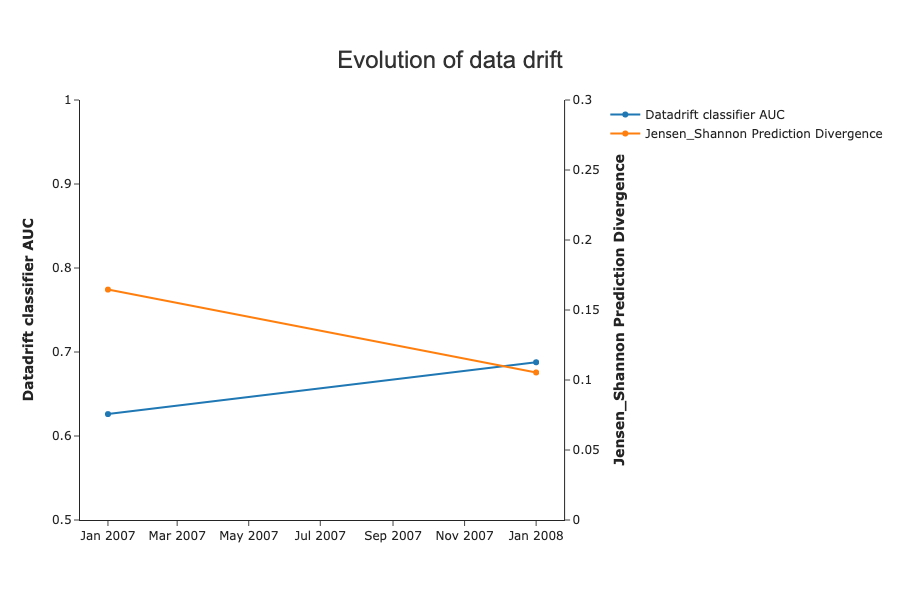

In [ ]:
SD.plot.generate_historical_datadrift_metric() # works if date_compile_auc and/or datadrift_file are filled

------

### Compile Drift et generate report for Year 2009

In [25]:
house_df_2009 = house_df.loc[house_df['YrSold'] == 2009]

y_df_2009=house_df_2009['SalePrice'].to_frame()
X_df_2009=house_df_2009[house_df_2009.columns.difference(['SalePrice','YrSold'])]
X_df_2009["MasVnrType"] = X_df_2009["MasVnrType"].fillna("NR")

In [26]:
SD = SmartDrift(df_current=X_df_2009,
                df_baseline=X_df_learning,
                deployed_model=regressor, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
                )

In [27]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = date(2009,1,1), # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "house_price_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The variable BsmtCond has mismatching unique values:
['Poor -Severe cracking, settling, or wetness'] | []

The variable Condition1 has mismatching unique values:
[] | ['Adjacent to East-West Railroad']

The variable Condition2 has mismatching unique values:
['Adjacent to arterial street'] | []

The variable Electrical has mismatching unique values:
[] | ['60 AMP Fuse Box and mostly knob & tube wiring (poor)']

The variable ExterCond has mismatching unique values:
['Excellent'] | []

The variable ExterQual has mismatching unique values:
['Fair'] | []

The variable Exterior1st has mismatching unique values:
['Brick Common', 'Cinder Block'] | ['Stone', 'Imitation Stucco']

The variable Exterior2nd has mismatching unique values:
['Brick Common', 'Cinder Block'] | ['Other']

The variable Functional has mismatching unique values:
['Major Deductions 2'] | []

The variable GarageCond has mismatching unique values:
['Excellent'] | ['Good']

The variable GarageQual has mismatching unique values:

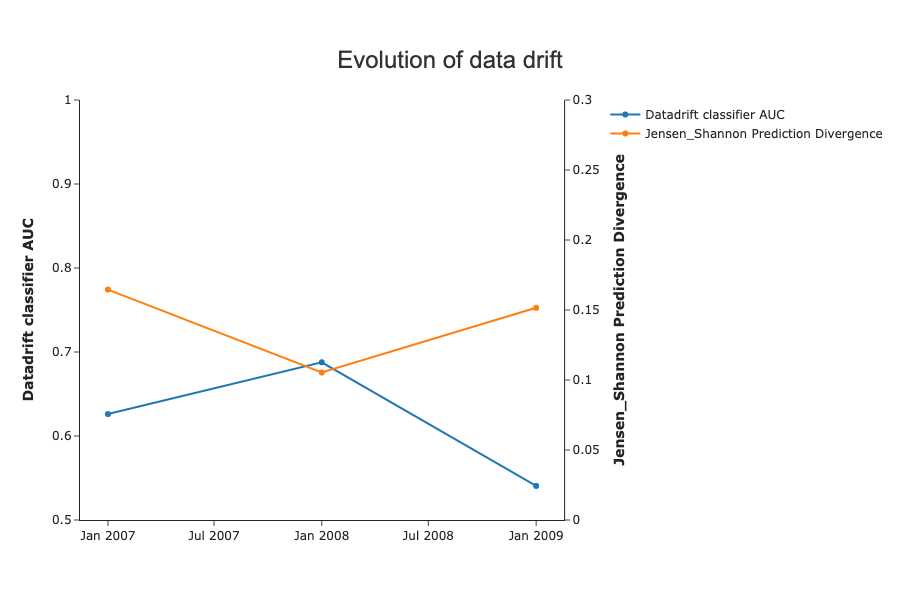

In [ ]:
SD.plot.generate_historical_datadrift_metric() # works if date_compile_auc and/or datadrift_file are filled

### Compile Drift et generate report for Year 2010

In [29]:
house_df_2010 = house_df.loc[house_df['YrSold'] == 2010]

y_df_2010=house_df_2010['SalePrice'].to_frame()
X_df_2010=house_df_2010[house_df_2010.columns.difference(['SalePrice','YrSold'])]
X_df_2010["MasVnrType"] = X_df_2010["MasVnrType"].fillna("NR")

In [30]:
SD = SmartDrift(df_current=X_df_2010,
                df_baseline=X_df_learning,
                deployed_model=regressor, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [31]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = date(2010,1,1), # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "house_price_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The variable Condition1 has mismatching unique values:
["Within 200' of East-West Railroad"] | []

The variable Electrical has mismatching unique values:
[] | ['60 AMP Fuse Box and mostly knob & tube wiring (poor)']

The variable ExterCond has mismatching unique values:
['Poor'] | []

The variable ExterQual has mismatching unique values:
['Fair'] | []

The variable Exterior1st has mismatching unique values:
['Asphalt Shingles'] | ['Stone', 'Imitation Stucco']

The variable Exterior2nd has mismatching unique values:
['Asphalt Shingles', 'Brick Common'] | ['Other', 'Stone']

The variable Functional has mismatching unique values:
[] | ['Major Deductions 1']

The variable GarageCond has mismatching unique values:
[] | ['Poor', 'Good']

The variable GarageQual has mismatching unique values:
[] | ['Good', 'Excellent', 'Poor']

The variable GarageType has mismatching unique values:
[] | ['More than one type of garage']

The variable Heating has mismatching unique values:
[] | ['Gas hot water 

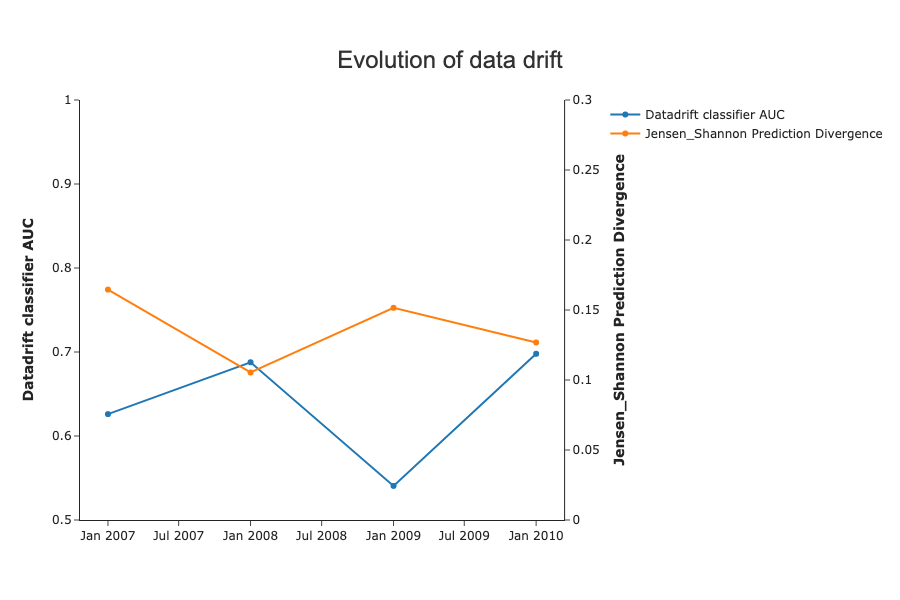

In [ ]:
SD.plot.generate_historical_datadrift_metric() # works if date_compile_auc and/or datadrift_file are filled

In [33]:
SD.generate_report(    
    output_file='report_house_price_datadrift_histo.html',    
    title_story="Data drift",
    title_description="""House price Data drift over time""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_house_price.yml" # Optional: add information on report
    )